In [1]:
import os
import random
import numpy as np
import tensorflow as tf

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Enforces deterministic behavior

# Load Dataset

* Firstly, I loaded the tensor flow dataset. 
* Then split the training set into 60% and 40% to end up with 15,000 examples for training, 10,000 for validation and 25,000 for testing.
* And the test set is already provided by the dataset.

In [ ]:

import tensorflow_datasets as tfds

train_data, validation_data, test_data = tfds.load(
    name = "imdb_reviews",
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True
)

In [3]:
# Shuffle the training data
train_data = train_data.shuffle(buffer_size=15000, seed=42)

In [4]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'If this film strikes you (as it did us and, apparently, others departing the theater) as disappointingly thin, it may be because the subject herself is mildly disappointing. The film faithfully presents us Bettie Page as she probably was: a playful almost-innocent from the rural South whose career as "the pinup queen of the universe" was for her just goofy, natural fun. Her eventual moral qualms, religious conversion and sudden departure from nude and bondage modeling are biographically accurate, yet hard to understand given how untroubled she seemed by her livelihood.<br /><br />There are many reasons to see this film even so, not least of which are the amazing b&w noir cinematography of W. Mott Hopfel III (complete with old fashioned wipes and dissolves), the 1950\'s-faithful acting of the cast under the direction of Mary Harron, pitch-perfect performances by some of our most underrated supporting actors (including Chris Bauer, L

In [5]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 1, 0, 0, 1, 0, 0, 1, 1, 0], dtype=int64)>

In [6]:
def count_labels(dataset):
    label_counts = {0: 0, 1: 0}
    for _, label in dataset:
        label_counts[int(label.numpy())] += 1
    return label_counts

train_counts = count_labels(train_data)
val_counts = count_labels(validation_data)
test_counts = count_labels(test_data)

print("Train set label distribution:", train_counts)
print("Validation set label distribution:", val_counts)
print("Test set label distribution:", test_counts)

Train set label distribution: {0: 7510, 1: 7490}
Validation set label distribution: {0: 4990, 1: 5010}
Test set label distribution: {0: 12500, 1: 12500}


Since the dataset is very well balanced across all splits, I don't need to apply any class weighting, oversampling or undersampling. 

# Data Preprocessing

### Convert tensors objects to Python lists

In [7]:
train_texts, train_labels = [], []

for text, label in train_data:
    train_texts.append(text.numpy().decode('utf-8').lower())
    train_labels.append(label.numpy())

print(len(train_texts))
print(len(train_labels))
print(train_texts[0])

15000
15000
i heard so much about this movie how it was a great slasher and one of those early 80's movies that die hard fans of most slasher movies just had to see. well, i rented it and i have to say that although it kept my attention as far as the suspense goes for most slasher films such as "april fools day", "friday 13th" and "prom night", this film could have been right up there with the above mentioned only it lacked true enthusiasm and potential from the characters as well as the on going story. characters that i found were unfortunate to be in this movie was the weirdo guy with the frizzy hair that kept creeping around the dorm and of course leading up to his true climatic role during the end with he faces the killer. another would be the dirty scruffy looking guy with the jean jacket, he could have played more roles in this movie that might have made the movie more interesting, instead, the movie played this guy as just another loser out there making unknown calls while he sl

In [8]:
val_texts, val_labels = [], []

for text, label in validation_data:
    val_texts.append(text.numpy().decode('utf-8').lower())
    val_labels.append(label.numpy())

print(len(val_texts))
print(len(val_labels))
print(val_texts[0])

10000
10000
this was a superb episode, one of the best of both seasons. down right horror for a change, with a story that is way way above the average moh episodes, if there is such a thing. a man's wife is almost burned to death in a tragic car wreck, in which he was driving. his airbag worked, her's didn't. she is burned beyond recognition (great makeup btw), and not given much of a chance to live without a full skin graft. but, even in a coma, she keeps dying but brought back by modern technology, and when she does die for a few minutes, her ghost appears as a very vengeful spirit. carnage of course ensues, and also some extremely gory killings, and also, some extremely sexy scenes. what more could you ask for, you might ask? well, not much, because this baby has it all, and a very satirical ending, that should leave a smile on most viewers faces. i just loved rob schmidt's (wrong turn) direction too, he has a great knack for horror. excellent episode, this is one i'm buying for sur

In [9]:
test_texts, test_labels = [], []

for text, label in test_data:
    test_texts.append(text.numpy().decode('utf-8').lower())
    test_labels.append(label.numpy())

print(len(test_texts))
print(len(test_labels))
print(test_texts[0])

25000
25000
there are films that make careers. for george romero, it was night of the living dead; for kevin smith, clerks; for robert rodriguez, el mariachi. add to that list onur tukel's absolutely amazing ding-a-ling-less. flawless film-making, and as assured and as professional as any of the aforementioned movies. i haven't laughed this hard since i saw the full monty. (and, even then, i don't think i laughed quite this hard... so to speak.) tukel's talent is considerable: ding-a-ling-less is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). ding-a-ling-less is a film whose time has come.


### Tokenize the texts

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

vocab_size = 10000
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_texts)

### Convert tokens to sequences

In [11]:
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

### Pad sequences for uniform input length

In [ ]:
import numpy as np

review_lengths = [len(text.split()) for text in train_texts]
lengths = np.array(review_lengths)
p95 = np.percentile(lengths, 95)
p90 = np.percentile(lengths, 90)
median = np.median(lengths)

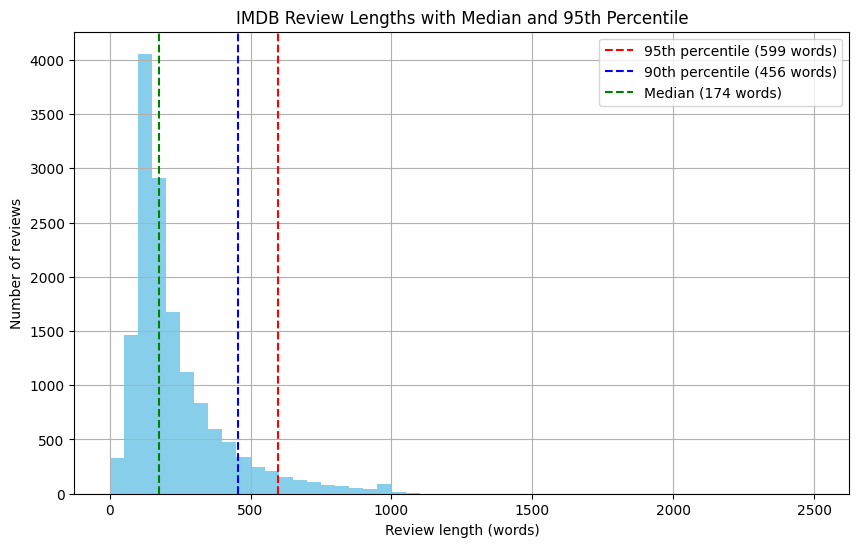

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(review_lengths, bins=np.arange(0, 2501, 50), color='skyblue')
plt.axvline(p95, color='red', linestyle='--', label=f'95th percentile ({int(p95)} words)')
plt.axvline(p90, color='blue', linestyle='--', label=f'90th percentile ({int(p90)} words)')
plt.axvline(median, color='green', linestyle='--', label=f'Median ({int(median)} words)')
plt.xlabel('Review length (words)')
plt.ylabel('Number of reviews')
plt.title('IMDB Review Lengths with Median and 95th Percentile')
plt.legend()
plt.grid(True)
plt.show()


* From the histogram, the median length of reviews is 174, and 90th percentile is at 456. 
* That's why I chose 300 as the max review length to retain enough information and keep the sequence length manageable for RNN model. 

In [35]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 300
padding_type = 'post'
truncating_type = 'post'

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=truncating_type)
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=truncating_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=truncating_type)

### Convert labels to numpy arrays

In [36]:
import numpy as np 

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

# Model Building using RNN

* For model building, I implemented an RNN model using TensorFlow and Keras. 
* I used an LSTM-based architecture with the following setup:
    * `Input(shape=(max_length,))` as input layer using max_length defined earlier
    * `Embedding(input_dim=vocab_size, output_dim=64)` as embedding layer
    * `LSTM(64)` as RNN layer using to capture sequential dependencies in text 
    * `Dropout(0.3)` to reduce overfitting
    * `Dense(32, activation='relu')` as fully connected hidden layer
    * `Dense(1, activation='sigmoid')` as final output for binary sentiment classification
* After that, I compiled the model with `binary_crossentropy` loss function and `Adam` optimizer with `learning rate=0.0005`

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Input(shape=(max_length,)),
    Embedding(input_dim=vocab_size, output_dim=64),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0005),
    metrics=['accuracy']
)

# Training RNN

* I trained the model for up to 30 epochs using early `EarlyStopping` as well as `ModelCheckpoint`. 
* Early stopping had `patience=5` and `restore_best_weights=True`, so training would stop if validation loss didn’t improve.
* I also used ModelCheckpoint to save the best model based on validation loss.
* Both callbacks were used during training to prevent overfitting and keep the best version of the model. 
* I saved this baseline model under models folder. 

In [38]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Save the best model based on val_loss
checkpoint = ModelCheckpoint(
    filepath="models/baseline_model.keras",
    monitor="val_loss",
    save_best_only=True,
)

# Combine both 
callbacks = [early_stop, checkpoint]

# Train the model
history = model.fit(
    train_padded, train_labels,
    validation_data=(val_padded, val_labels),
    epochs=30,
    batch_size=32,
    shuffle=False,
    callbacks=callbacks
)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 85ms/step - accuracy: 0.5099 - loss: 0.6932 - val_accuracy: 0.5034 - val_loss: 0.6932
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 84ms/step - accuracy: 0.5103 - loss: 0.6906 - val_accuracy: 0.5229 - val_loss: 0.6913
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 86ms/step - accuracy: 0.5600 - loss: 0.6547 - val_accuracy: 0.5529 - val_loss: 0.6733
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 85ms/step - accuracy: 0.5889 - loss: 0.5980 - val_accuracy: 0.5491 - val_loss: 0.7339
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 87ms/step - accuracy: 0.5970 - loss: 0.5665 - val_accuracy: 0.5420 - val_loss: 0.8485
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - accuracy: 0.6131 - loss: 0.5531 - val_accuracy: 0.5420 - val_loss: 0.7744
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 86ms/step - accuracy: 0.6538 - loss: 0.5219 - val_accuracy: 0.8029 - val_loss: 0.5417
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - accuracy: 0.8602 - loss: 0.3498 - 

# Model Evaluation

* I plotted learning curves to see accuracy and loss over epochs. 
* Accuracy plot shows that model is learning well. Both Training and Validation accuracy improve. But around epoch 7, validation accuracy stops improving. 
* In the loss plot, training loss keeps going down, but validation loss hits a low around epoch 7, then starts increasing. 

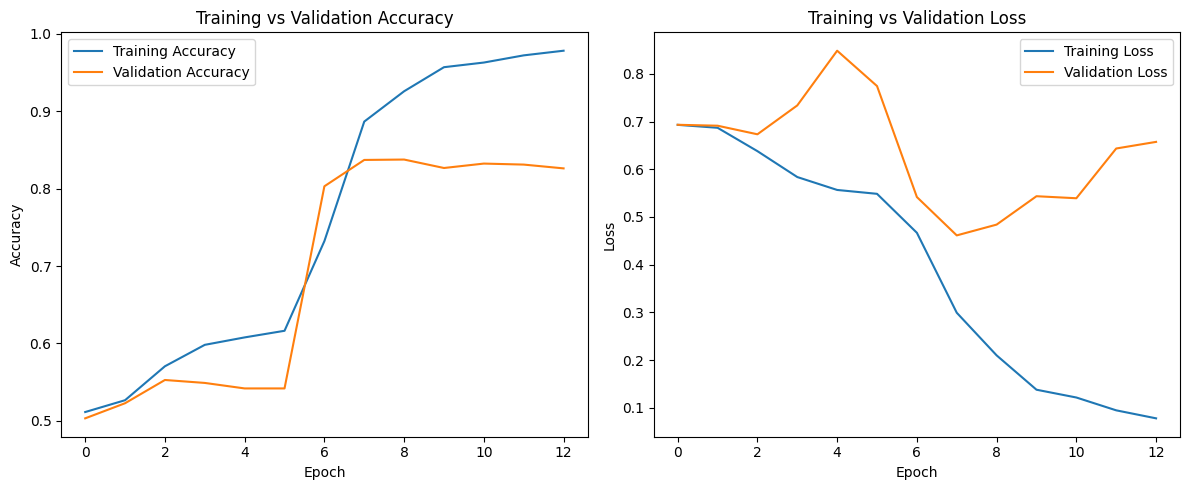

In [40]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [39]:
test_loss, test_acc = model.evaluate(test_padded, test_labels)
print(f"Test Accuracy: {test_acc:.2f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.8342 - loss: 0.4647
Test Accuracy: 0.83


In [41]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

y_pred_proba = model.predict(test_padded)
y_pred_classes = (y_pred_proba > 0.5).astype(int)

print(classification_report(test_labels, y_pred_classes, target_names=["Negative", "Positive"]))

782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step
              precision    recall  f1-score   support

    Negative       0.84      0.82      0.83     12500
    Positive       0.82      0.85      0.84     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



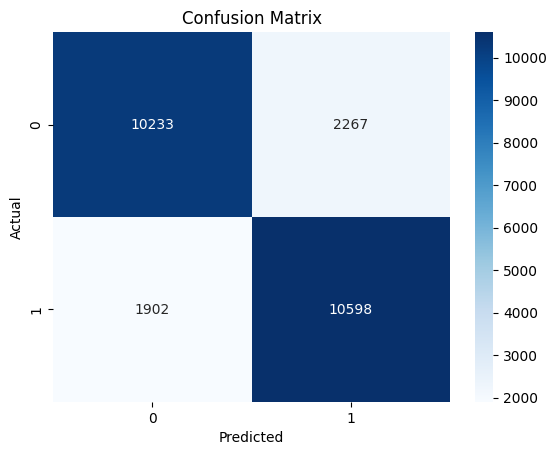

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

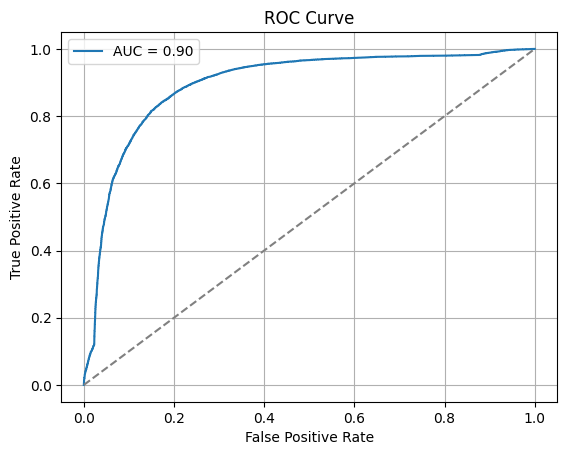

In [43]:
from sklearn.metrics import roc_auc_score, roc_curve

auc = roc_auc_score(test_labels, y_pred_proba)

fpr, tpr, thresholds = roc_curve(test_labels, y_pred_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

**Baseline Performance:**

* On the test set, the model achieved an accuracy of 83%, which is consistent with what I saw during validation. 
* Precision and recall are balanced across both classes. We have F1-score of 0.83 for negative and 0.84 for positive reviews. 
* The confusion matrix shows that it correctly predicted 10,233 negative and 10,598 positive reviews. 
* Meanwhile, there are some misclassifications on both sides (2,267 false positives and 1,902 false negatives). 
* The ROC AUC score is 0.90, which means the model is quite good at distinguishing between the two classes. 
* Overall, this baseline model's performance is solid and well-balanced.

# Hyperparameter Tuning

* Even though, the baseline model is strong, for better generalization, I experimented with hyperparameters tuning by adjusting
    * Number of LSTM layers
    * Number of units in each layer
    * Dropout rates
    * Learning rates

### Adjust Number of LSTM layers

* Since the baseline used a single `LSTM(64)` layer, I added another LSTM layer to increase depth and let the model learn higher-level sequence patterns.
* I used return_sequences=True in the first LSTM so the second layer could process the full output sequence. Ref: https://www.tensorflow.org/guide/keras/working_with_rnns#outputs_and_states
* I keep the rest of the setup as the baseline in order to compare the effects of only adding another LSTM layer. 

In [69]:
model = Sequential([
    Input(shape=(max_length,)),
    Embedding(input_dim=vocab_size, output_dim=64),
    LSTM(64, dropout=0.2, return_sequences=True),
    LSTM(32, dropout=0.2),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0005),
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath="models/tuned_lstm64-32_do30_lr0005_bs32.keras",
    monitor="val_loss",
    save_best_only=True,
)

callbacks = [early_stop, checkpoint]

history = model.fit(
    train_padded, train_labels,
    validation_data=(val_padded, val_labels),
    epochs=30,
    batch_size=32,
    shuffle=False,
    callbacks=callbacks
)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 96s 180ms/step - accuracy: 0.5072 - loss: 0.6932 - val_accuracy: 0.5039 - val_loss: 0.6929
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 84s 179ms/step - accuracy: 0.5162 - loss: 0.6928 - val_accuracy: 0.5260 - val_loss: 0.6917
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 90s 192ms/step - accuracy: 0.5422 - loss: 0.6820 - val_accuracy: 0.5491 - val_loss: 0.6654
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 87s 185ms/step - accuracy: 0.5898 - loss: 0.6210 - val_accuracy: 0.5634 - val_loss: 0.6653
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 91s 193ms/step - accuracy: 0.6110 - loss: 0.5787 - val_accuracy: 0.5656 - val_loss: 0.6892
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 86s 183ms/step - accuracy: 0.6212 - loss: 0.5589 - val_accuracy: 0.5693 - val_loss: 0.7319
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 78s 165ms/step - accuracy: 0.6687 - loss: 0.5172 - val_accuracy: 0.8027 - val_loss: 0.5574
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 78s 167ms/step - accuracy: 0.8337 - loss: 0

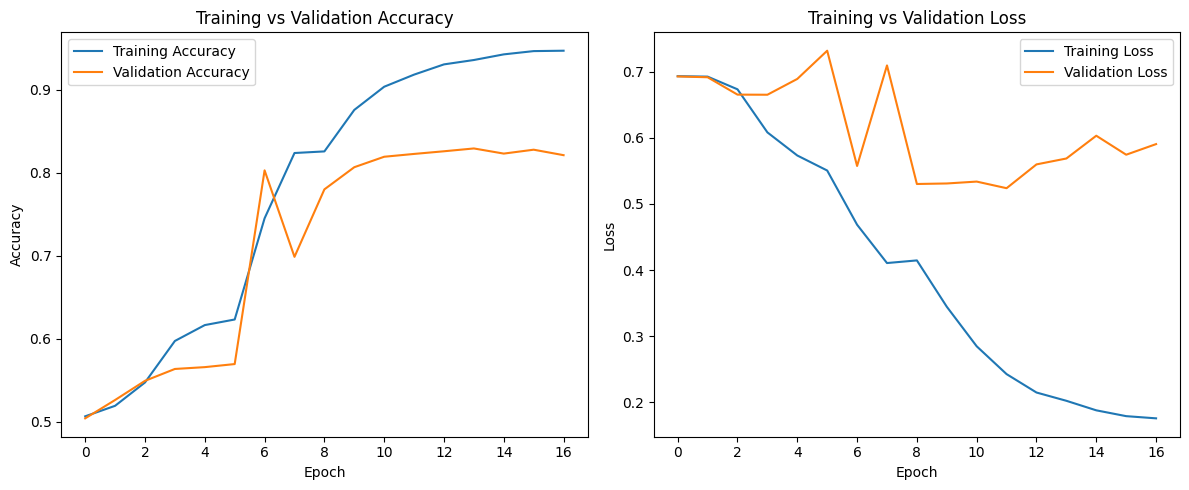

In [70]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

* Based on the learning curves, we can see that the setup helped the training accuracy, but validation accuracy still leveled off around epoch 8.
* The loss curve shows clear overfitting after that point. 

In [71]:
test_loss, test_acc = model.evaluate(test_padded, test_labels)
print(f"Test Accuracy: {test_acc:.2f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy: 0.8202 - loss: 0.5322
Test Accuracy: 0.82


In [72]:
y_pred_proba = model.predict(test_padded)
y_pred_classes = (y_pred_proba > 0.5).astype(int)

print(classification_report(test_labels, y_pred_classes, target_names=["Negative", "Positive"]))

782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step
              precision    recall  f1-score   support

    Negative       0.84      0.78      0.81     12500
    Positive       0.79      0.86      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



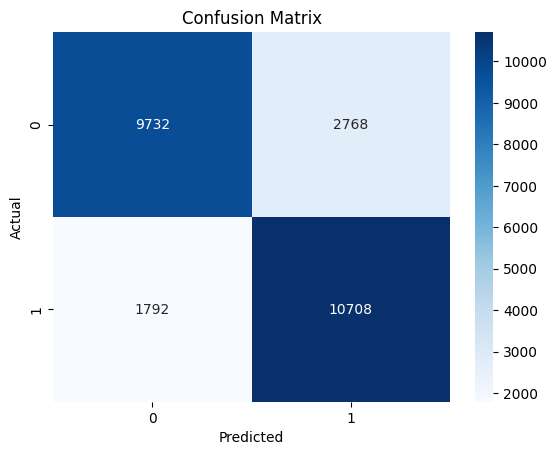

In [73]:
cm = confusion_matrix(test_labels, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

* After adding a second LSTM layer, the test accuracy didn't improve but slightly decreased to 82%.
* The precision and recall were still balanced, with F1-score being 0.81 for negative and 0.82 for positive reviews. 
* The confusion matrix shows 9,732 true negatives and 10,708 true positives. 
* Overall, this didn't improve compared to baseline model that I built earlier. 

### Add More Units

* Next, I tried increasing the number of units in each LSTM layer to see if that helps the model capture more complex patterns in the review sequences. 
* I increased the first LSTM layer to 128 units and kept `return_sequences=True` so the second LSTM (with 64 units) can process the full sequence output.
* I’ll keep the rest of the setup the same so I can isolate the effect of just increasing the LSTM size.

In [75]:
model = Sequential([
    Input(shape=(max_length,)),
    Embedding(input_dim=vocab_size, output_dim=64),
    LSTM(128, dropout=0.2, return_sequences=True),
    LSTM(64, dropout=0.2),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0005),
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath="models/tuned_lstm128-64_do30_lr0005_bs32.keras",
    monitor="val_loss",
    save_best_only=True,
)

callbacks = [early_stop, checkpoint]

history = model.fit(
    train_padded, train_labels,
    validation_data=(val_padded, val_labels),
    epochs=30,
    batch_size=32,
    shuffle=False,
    callbacks=callbacks
)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 114s 235ms/step - accuracy: 0.5027 - loss: 0.6934 - val_accuracy: 0.5023 - val_loss: 0.6921
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 110s 235ms/step - accuracy: 0.5242 - loss: 0.6873 - val_accuracy: 0.5292 - val_loss: 0.6918
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 113s 242ms/step - accuracy: 0.5694 - loss: 0.6487 - val_accuracy: 0.5453 - val_loss: 0.7057
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 112s 238ms/step - accuracy: 0.5747 - loss: 0.6372 - val_accuracy: 0.5497 - val_loss: 0.7165
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 111s 236ms/step - accuracy: 0.6050 - loss: 0.5890 - val_accuracy: 0.7422 - val_loss: 0.6732
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 113s 240ms/step - accuracy: 0.7936 - loss: 0.4762 - val_accuracy: 0.7712 - val_loss: 0.5582
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 112s 238ms/step - accuracy: 0.8462 - loss: 0.3791 - val_accuracy: 0.8236 - val_loss: 0.4808
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 112s 238ms/step - accuracy: 0.9014 -

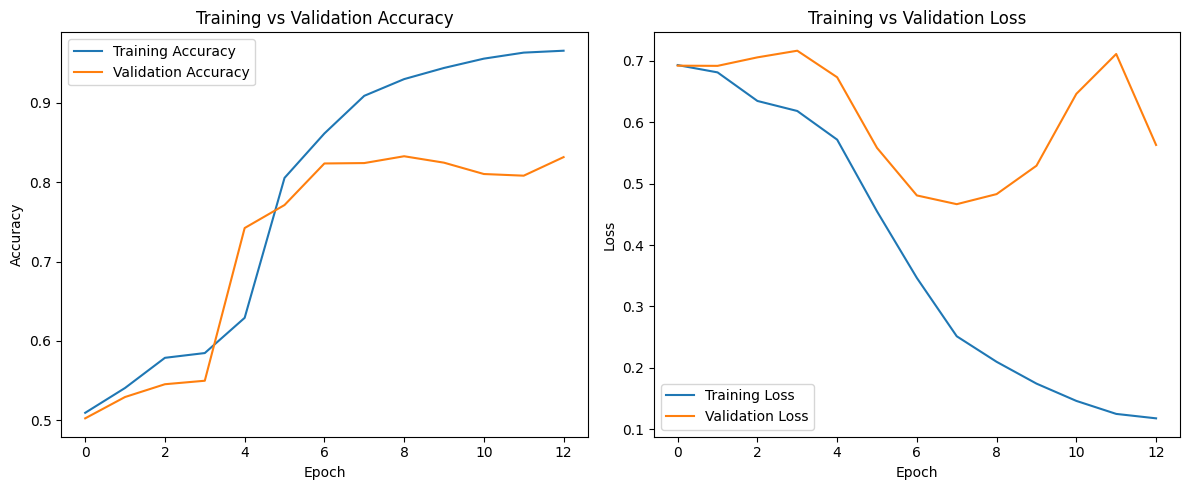

In [76]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

* After increasing the LSTM units, training accuracy improved even more, but validation accuracy still peaked around epoch 8. 
* The loss plot shows the same overfitting pattern. The training loss keeps dropping, but validation loss starts rising again after that point. 
* So while the deeper setup helped learning, it didn’t fully solve the overfitting issue.

In [77]:
test_loss, test_acc = model.evaluate(test_padded, test_labels)
print(f"Test Accuracy: {test_acc:.2f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 60s 77ms/step - accuracy: 0.8267 - loss: 0.4622
Test Accuracy: 0.83


In [78]:
y_pred_proba = model.predict(test_padded)
y_pred_classes = (y_pred_proba > 0.5).astype(int)

print(classification_report(test_labels, y_pred_classes, target_names=["Negative", "Positive"]))

782/782 ━━━━━━━━━━━━━━━━━━━━ 60s 75ms/step
              precision    recall  f1-score   support

    Negative       0.83      0.82      0.83     12500
    Positive       0.82      0.83      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



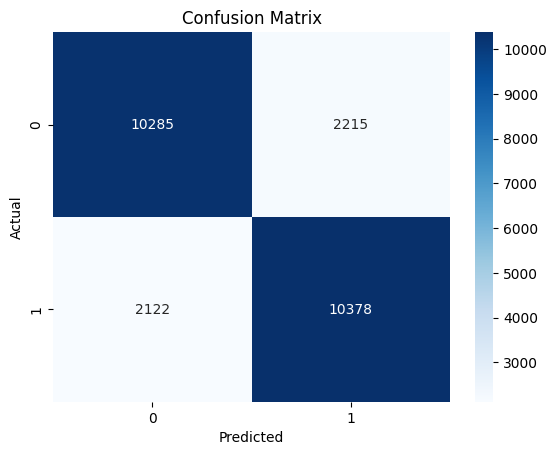

In [79]:
cm = confusion_matrix(test_labels, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

* With the increased LSTM units, the test accuracy came out to 83%, matching the baseline. 
* Precision and recall stayed balanced across both classes, with an F1-score of 0.83 for both negative and positive reviews. 
* The confusion matrix shows 10,285 true negatives and 10,378 true positives, which is slightly better than the previous tuned version. 
* So overall, this setup didn’t drastically change performance, but it maintained strong, consistent results that I observed at the baseline model.

### Adjust dropout rate

* After that, I tested different dropout rates (0.2 to 0.5) to see how regularization affects performance. 
* I used the same model structure and just changed the dropout values in both LSTM layers and the final dropout layer.

In [87]:
from tensorflow.keras.models import load_model

dropout_rates = [0.2, 0.3, 0.4, 0.5]
results = {}

for rate in dropout_rates:
    print(f"\nTraining with dropout={rate}")

    model = Sequential([
        Input(shape=(max_length,)),
        Embedding(input_dim=vocab_size, output_dim=64),
        LSTM(128, dropout=rate, return_sequences=True),
        LSTM(64, dropout=rate),        
        Dropout(rate),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.0005),
        metrics=['accuracy']
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    checkpoint_path = f"models/tuned_lstm128-64_do{int(rate*100)}_lr0005_bs32.keras"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_loss",
        save_best_only=True,
    )

    callbacks = [early_stop, checkpoint]

    history = model.fit(
        train_padded, train_labels,
        validation_data=(val_padded, val_labels),
        epochs=30,
        batch_size=32,
        shuffle=False,
        callbacks=callbacks
    )

    val_acc = max(history.history['val_accuracy'])
    val_loss = min(history.history['val_loss'])

    best_model = load_model(checkpoint_path)

    test_loss, test_acc = best_model.evaluate(test_padded, test_labels)

    y_pred_proba = best_model.predict(test_padded)
    y_pred_classes = (y_pred_proba > 0.5).astype(int)

    report = classification_report(test_labels, y_pred_classes, target_names=["Negative", "Positive"], output_dict=True)
    cm = confusion_matrix(test_labels, y_pred_classes)

    results[rate] = {
        'val_acc': val_acc,
        'val_loss': val_loss,
        'test_acc': test_acc,
        'confusion_matrix': cm,
        'classification_report': report
    }


Training with dropout=0.2
Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 117s 242ms/step - accuracy: 0.5048 - loss: 0.6934 - val_accuracy: 0.5010 - val_loss: 0.6927
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 114s 242ms/step - accuracy: 0.5239 - loss: 0.6980 - val_accuracy: 0.5549 - val_loss: 0.6872
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 109s 232ms/step - accuracy: 0.5502 - loss: 0.6873 - val_accuracy: 0.5559 - val_loss: 0.6867
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 112s 239ms/step - accuracy: 0.5564 - loss: 0.6881 - val_accuracy: 0.5570 - val_loss: 0.6863
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 110s 235ms/step - accuracy: 0.5606 - loss: 0.6864 - val_accuracy: 0.5011 - val_loss: 0.6936
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 110s 234ms/step - accuracy: 0.5018 - loss: 0.6936 - val_accuracy: 0.4990 - val_loss: 0.6934
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 109s 232ms/step - accuracy: 0.5093 - loss: 0.6931 - val_accuracy: 0.5035 - val_loss: 0.6930
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 108s 231m

c:\Users\Home\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Home\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Home\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

469/469 ━━━━━━━━━━━━━━━━━━━━ 127s 248ms/step - accuracy: 0.5065 - loss: 0.6935 - val_accuracy: 0.5040 - val_loss: 0.6931
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 119s 253ms/step - accuracy: 0.5050 - loss: 0.6930 - val_accuracy: 0.5036 - val_loss: 0.6928
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 117s 249ms/step - accuracy: 0.5190 - loss: 0.6937 - val_accuracy: 0.4990 - val_loss: 0.6942
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 115s 246ms/step - accuracy: 0.5020 - loss: 0.6933 - val_accuracy: 0.5238 - val_loss: 0.6889
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 114s 244ms/step - accuracy: 0.5168 - loss: 0.6906 - val_accuracy: 0.4990 - val_loss: 0.6907
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 114s 243ms/step - accuracy: 0.5355 - loss: 0.6873 - val_accuracy: 0.5358 - val_loss: 0.6873
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 113s 241ms/step - accuracy: 0.5341 - loss: 0.6870 - val_accuracy: 0.4990 - val_loss: 0.6932
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 116s 247ms/step - accuracy: 0.5046 - loss: 0.69

In [88]:
import pandas as pd

summary = []

for rate, metrics in results.items():
    summary.append({
        'Dropout': rate,
        'Val Accuracy': round(metrics['val_acc'], 4),
        'Val Loss': round(metrics['val_loss'], 4),
        'Test Accuracy': round(metrics['test_acc'], 4),
        'F1-Score (Negative)': round(metrics['classification_report']['Negative']['f1-score'], 4),
        'F1-Score (Positive)': round(metrics['classification_report']['Positive']['f1-score'], 4)
    })

summary_df = pd.DataFrame(summary)

print("Dropout Rate Tuning Summary:")
print(summary_df.to_string(index=False))


Dropout Rate Tuning Summary:
 Dropout  Val Accuracy  Val Loss  Test Accuracy  F1-Score (Negative)  F1-Score (Positive)
     0.2        0.8328    0.4609         0.8117               0.8203               0.8023
     0.3        0.5637    0.6808         0.5495               0.3265               0.6616
     0.4        0.5042    0.6925         0.5000               0.6667               0.0000
     0.5        0.8443    0.4256         0.8198               0.8288               0.8098


* Out of all the dropout rates, 0.5 gave the best overall result since it had the highest validation accuracy (0.84) and strong F1-scores for both classes. 
* Dropout 0.2 also did well, but 0.3 and 0.4 clearly underperformed, especially with validation and test accuracy dropping a lot. 
* So increasing dropout to 0.5 helped regularize the model without hurting performance.

### Adjust learning rate

* Finally, I ran experiments with different learning rates (0.001 to 0.0001) to see how it impacts convergence and generalization. 
* I kept the baseline model architecture and only adjusted the learning rate in the optimizer to isolate its effect.

In [89]:
learning_rates = [0.001, 0.0005, 0.0003, 0.0001]
results = {}

for lr in learning_rates:
    print(f"\nTraining with learning rate={lr}")
    
    model = Sequential([
        Input(shape=(max_length,)),
        Embedding(input_dim=vocab_size, output_dim=64),
        LSTM(64, dropout=0.2, recurrent_dropout=0.2),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    checkpoint = ModelCheckpoint(
        filepath=f"models/tuned_lstm64_do20_lr{str(lr).replace('.', '')}_bs32.keras",
        monitor="val_loss",
        save_best_only=True,
    )

    callbacks = [early_stop, checkpoint]

    history = model.fit(
        train_padded, train_labels,
        validation_data=(val_padded, val_labels),
        epochs=30,
        batch_size=32,
        shuffle=False,
        callbacks=callbacks
    )
    
    val_acc = max(history.history['val_accuracy'])
    val_loss = min(history.history['val_loss'])

    best_model = load_model(checkpoint_path)

    test_loss, test_acc = best_model.evaluate(test_padded, test_labels)

    y_pred_proba = best_model.predict(test_padded)
    y_pred_classes = (y_pred_proba > 0.5).astype(int)

    report = classification_report(test_labels, y_pred_classes, target_names=["Negative", "Positive"], output_dict=True)
    cm = confusion_matrix(test_labels, y_pred_classes)

    results[lr] = {
        'val_acc': val_acc,
        'val_loss': val_loss,
        'test_acc': test_acc,
        'confusion_matrix': cm,
        'classification_report': report
    }


Training with learning rate=0.001
Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 72s 142ms/step - accuracy: 0.5055 - loss: 0.6935 - val_accuracy: 0.5103 - val_loss: 0.6923
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 65s 138ms/step - accuracy: 0.5248 - loss: 0.6902 - val_accuracy: 0.5284 - val_loss: 0.6873
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 65s 139ms/step - accuracy: 0.5663 - loss: 0.6530 - val_accuracy: 0.5357 - val_loss: 0.7030
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 65s 138ms/step - accuracy: 0.5898 - loss: 0.6045 - val_accuracy: 0.5415 - val_loss: 0.7301
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 64s 137ms/step - accuracy: 0.6029 - loss: 0.5748 - val_accuracy: 0.5338 - val_loss: 0.8304
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 65s 138ms/step - accuracy: 0.6148 - loss: 0.5597 - val_accuracy: 0.5426 - val_loss: 0.8771
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 63s 135ms/step - accuracy: 0.6175 - loss: 0.5457 - val_accuracy: 0.5410 - val_loss: 0.9256
782/782 ━━━━━━━━━━━━━━━━━━━━ 59s 74ms/step - acc

In [90]:
import pandas as pd

summary = []

for lr, metrics in results.items():
    summary.append({
        'Learning Rate': lr,
        'Val Accuracy': round(metrics['val_acc'], 4),
        'Val Loss': round(metrics['val_loss'], 4),
        'Test Accuracy': round(metrics['test_acc'], 4),
        'F1-Score (Negative)': round(metrics['classification_report']['Negative']['f1-score'], 4),
        'F1-Score (Positive)': round(metrics['classification_report']['Positive']['f1-score'], 4)
    })

summary_df = pd.DataFrame(summary)
summary_df = summary_df.sort_values(by='Test Accuracy', ascending=False)

print("Learning Rate Tuning Summary:")
print(summary_df.to_string(index=False))


Learning Rate Tuning Summary:
 Learning Rate  Val Accuracy  Val Loss  Test Accuracy  F1-Score (Negative)  F1-Score (Positive)
        0.0010        0.5426    0.6873         0.8198               0.8288               0.8098
        0.0005        0.5505    0.6814         0.8198               0.8288               0.8098
        0.0003        0.7738    0.5549         0.8198               0.8288               0.8098
        0.0001        0.7569    0.5528         0.8198               0.8288               0.8098


* All learning rates gave the same test accuracy (81.98%) and F1-scores. 
* But 0.0003 had the highest validation accuracy (0.7738) and lowest val loss, making it the best choice overall.

# Comparative Analysis

* To compare with the RNN model, I implemented a simple feedforward neural network (FFNN) for the same task. 
* I used an embedding layer followed by a `Flatten()` layer to convert the sequences into a dense input for the fully connected layers. 
* The goal was to see how a non-sequential model performs when the temporal relationships in the text are ignored. 
* I kept the architecture simple using two dense layers with ReLU, same `dropout=0.2` for regularization, and the same training setup as my RNN model. 
* This lets me directly compare how well each model handles the classification task.

In [91]:
from tensorflow.keras.layers import Flatten

model_ffnn = Sequential([
    Input(shape=(max_length,)),
    Embedding(input_dim=vocab_size, output_dim=64),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_ffnn.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0005),
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model_ffnn.fit(
    train_padded, train_labels,
    validation_data=(val_padded, val_labels),
    epochs=30,
    batch_size=32,
    shuffle=False,
    callbacks=callbacks
)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.5503 - loss: 0.6695 - val_accuracy: 0.8130 - val_loss: 0.4029
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.8863 - loss: 0.2811 - val_accuracy: 0.8444 - val_loss: 0.4110
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.9841 - loss: 0.0556 - val_accuracy: 0.8264 - val_loss: 0.6002
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.9980 - loss: 0.0120 - val_accuracy: 0.8408 - val_loss: 0.6356
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.9996 - loss: 0.0025 - val_accuracy: 0.8387 - val_loss: 0.6987
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 1.0000 - loss: 7.2872e-04 - val_accuracy: 0.8359 - val_loss: 0.7694


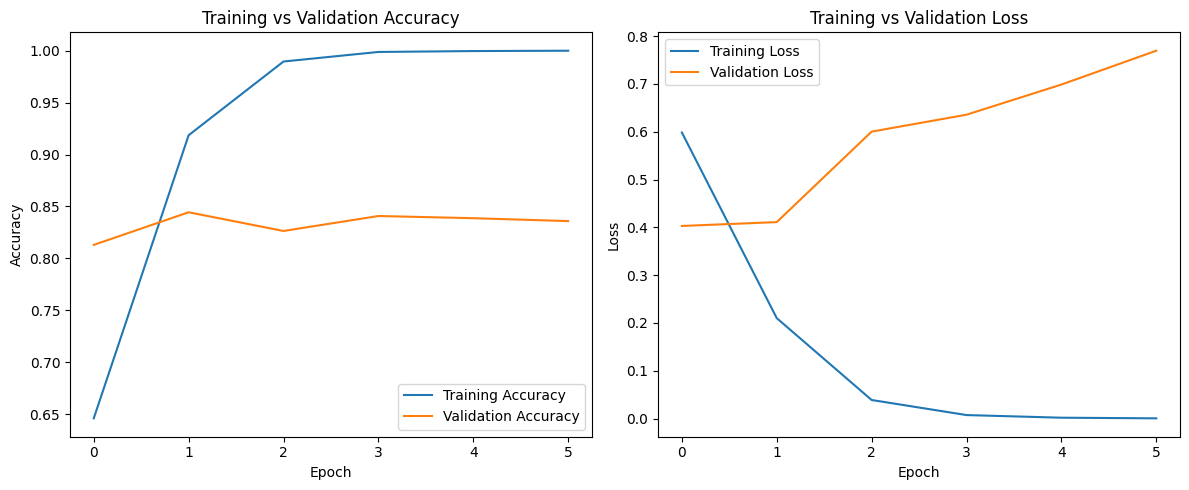

In [93]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

* The FFNN started off okay, but it overfit really fast. 
* Training accuracy hit nearly 100%, while validation accuracy peaked early and stayed flat after a few epochs.
* In the loss curve, the validation loss kept rising after just a couple epochs. 
* So, even though it learned fast, it didn’t generalize well compared to the RNN. 

In [ ]:
test_loss, test_acc = model_ffnn.evaluate(test_padded, test_labels)
print(f"Test Accuracy: {test_acc:.2f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8031 - loss: 0.4227
Test Accuracy: 0.80


In [96]:
y_pred_proba = model_ffnn.predict(test_padded)
y_pred_classes = (y_pred_proba > 0.5).astype(int)

print(classification_report(test_labels, y_pred_classes, target_names=["Negative", "Positive"]))

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
              precision    recall  f1-score   support

    Negative       0.74      0.91      0.82     12500
    Positive       0.89      0.69      0.77     12500

    accuracy                           0.80     25000
   macro avg       0.81      0.80      0.80     25000
weighted avg       0.81      0.80      0.80     25000



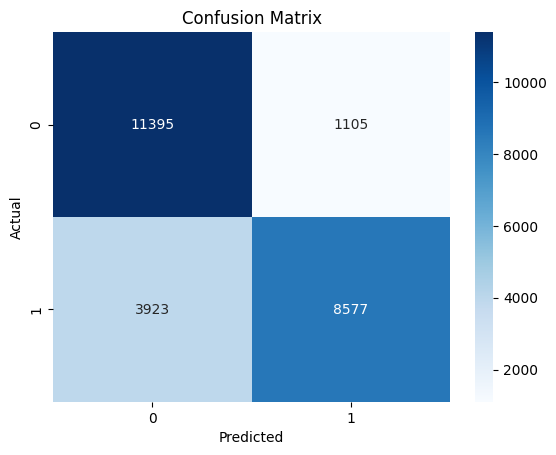

In [97]:
cm = confusion_matrix(test_labels, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Analysis**
* The feedforward neural network (FFNN) achieved a test accuracy of 80%, slightly lower than the RNN’s 83%. While the FFNN performed reasonably well on negative reviews (F1-score: 0.82), it struggled more with positives (F1-score: 0.77), showing a tendency to favor the negative class. This imbalance is reflected in the confusion matrix, where it misclassified 3,923 positive reviews as negative. In contrast, the RNN maintained better balance, with F1-scores above 0.83 for both classes, making it more reliable across sentiments.
* Training-wise, the FFNN learned quickly and reached high accuracy early on, but it overfit just as fast. Its validation accuracy plateaued after a few epochs while the loss kept increasing. The RNN, on the other hand, improved more gradually and showed smoother learning curves with stronger generalization to the validation and test sets.
* Overall, the FFNN’s main strength is its simplicity and speed since it’s easy to train and works decently when training time or resources are limited. However, its major limitation is the lack of sequential awareness, which is critical in text-based tasks. The RNN’s ability to process temporal patterns gave it a clear advantage here, making it a better fit for sentiment classification where context and word order matter. Despite taking longer to train and being more sensitive to tuning, the RNN ultimately delivered more consistent and balanced results.